# Analyzing SAT Performance of Public Schools in New York

#### Linna Ha & Chuck Zhu
#### Final Project for Data Bootcamp, Fall 2017

<div class="inline-block"> <img src="http://tribunacampeche.com/wp-content/uploads/2017/05/cenev.png" </div> 



## Background

The competition to get the best SAT score is more and more [fierce](https://www.applerouth.com/blog/2015/01/14/raising-the-bar-with-the-new-sat/). Everyone wants to go to the best high school in order to get better scores on standardized tests such as the SAT. The problem is students seldom know what is the real factor that determines a good school compared to a bad one. Public schools have so many different factors such as household income, teacher involvement, and school attendance. As the SAT continues to play a large role in a student's college and even career opportunities, we want to explore what specific factors have the largest impact in the highest and lowest SAT scores in public high schools in New York City.

## Data Source

New York City provides alot of open data on the public education system. We will be using the most [recent high school quality report (2014-2015)](https://data.cityofnewyork.us/download/vrfr-9k4d/application%2Fvnd.ms-excel) which evaluates students performance and achievement based on SAT scores. The data, provided by Department of Education, contains a **district borough number (DBN)** column which classifies each district a school is located. It also includes over 30+ parameters such as economic need index, percentage in temporary housing, and safety of students. The dataset is in the from of an excel sheet with 6 tabs, which has been converted into a CSV and uploaded to github for easy access. 


## Libraries and API


Of the packages discussed in class, we will be using:
* `pandas` to create dataframes
* `numpy` for computations
* `Census` an API to merge income data with zipcodes
* `matplotlib` to graph data
* `statsmodels` to make linear regression analysis

New packages used are:
* `googlegeocoder` to align data with zipcodes 
* `geopandas` to create maps from a shapefile
* `Seaborn` to create statistical visualizations

In [1]:
# import packages 
import sys
import pandas as pd                   
import matplotlib.pyplot as plt      
import numpy as np                    
import seaborn as sns
import statistics
from scipy import stats

from googlegeocoder import GoogleGeocoder #to match up DBN with zipcode

from census import Census            
from us import states   

import statsmodels.api as sm
import statsmodels.formula.api as smf

import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona 
%matplotlib inline                     

/Users/zhujunhan/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
api_key = "670c60e67279b6125d24adb8a5ab50638d3f1ac7"
c = Census(api_key)

## Cleaning and Merging Datasets

From the dataset, we will be using two tabs which include the SAT scores (satdf) and the performance variables (summary).

In [3]:
part_1 ="https://raw.githubusercontent.com/chuckzhuisme/my_first_repository/"
part_2 = "master/Copy%20of%202014_2015_HS_SQR_Scores.csv"
part_3 = 'master/Copy%20of%202014_2015_HS_SQR_Results_Summary.csv'
hs_scores = part_1 + part_2
hs_summary = part_1 + part_3

satdf = pd.read_csv(hs_scores, encoding='latin-1') #file with standardized test scores
summary = pd.read_csv(hs_summary, encoding='latin-1') #variable file

In [4]:
satdf.shape

(491, 90)

There are more than 90 columns in the scores file. We will make a copy of the dataframe with the just the columns of the SAT scores and DBN. 

In [5]:
df = satdf[['DBN', 'School Name', 'Average Score SAT Math','Average Score SAT Critical Reading', \
             'Average Score SAT Writing']].copy()
col_list= list(df)
col_list.remove('DBN')
col_list.remove('School Name')
col_list
df['Average SAT Score for Three sections'] = df[col_list].sum(axis=1)
df.head()

,DBN,School Name,Average Score SAT Math,Average Score SAT Critical Reading,Average Score SAT Writing,Average SAT Score for Three sections
0,01M292,Henry Street School for International Studies,410.0,406.0,381.0,1197.0
1,01M448,University Neighborhood High School,437.0,355.0,352.0,1144.0
2,01M450,East Side Community School,454.0,428.0,445.0,1327.0
3,01M509,Marta Valle High School,438.0,413.0,394.0,1245.0
4,01M539,"New Explorations into Science, Technology and ...",657.0,601.0,601.0,1859.0


In [6]:
summary.shape

(491, 40)

In [7]:
#The variable dataset has 40 columns. Let's choose the ones we need.

numerical = summary[['DBN', 'School Name', 'Enrollment','Student Attendance Rate', \
        'Economic Need Index', 'Average Grade 8 English Proficiency', 'Average Grade 8 Math Proficiency', \
        'Percent English Language Learners', \
        'Rigorous Instruction - Percent Positive', 'Percent Asian', 'Percent Black', \
        'Percent Hispanic', 'Percent White']].copy()

After selecting specific columns from both sets, we can merge together the two files. 

In [8]:
# Now lets merge the two dataframes together with DBN

del numerical['School Name']
combo_num = pd.merge(df, numerical,
                 on='DBN',       
                 how='left',        
                 indicator=True)  
combo_num.head()

,DBN,School Name,Average Score SAT Math,Average Score SAT Critical Reading,Average Score SAT Writing,Average SAT Score for Three sections,Enrollment,Student Attendance Rate,Economic Need Index,Average Grade 8 English Proficiency,Average Grade 8 Math Proficiency,Percent English Language Learners,Rigorous Instruction - Percent Positive,Percent Asian,Percent Black,Percent Hispanic,Percent White,_merge
0,01M292,Henry Street School for International Studies,410.0,406.0,381.0,1197.0,255,76.6%,83.2%,2.18,2.06,12.7%,72%,13.2%,24.4%,56.6%,3.9%,both
1,01M448,University Neighborhood High School,437.0,355.0,352.0,1144.0,304,88.0%,81.2%,2.27,2.37,19.4%,85%,29.9%,25.0%,41.1%,3.3%,both
2,01M450,East Side Community School,454.0,428.0,445.0,1327.0,666,93.8%,61.0%,2.66,2.63,1.8%,92%,9.4%,22.1%,57.9%,8.3%,both
3,01M509,Marta Valle High School,438.0,413.0,394.0,1245.0,363,76.8%,76.7%,2.28,2.09,9.1%,86%,5.8%,39.9%,51.2%,2.5%,both
4,01M539,"New Explorations into Science, Technology and ...",657.0,601.0,601.0,1859.0,1735,95.2%,25.7%,3.50,3.53,0.2%,81%,38.5%,13.3%,18.0%,28.6%,both


In [9]:
rating = summary[['DBN', 'School Name', 'Quality Review - How clearly are high expectations communicated to students and staff?', \
        'Quality Review - How interesting and challenging is the curriculum?', \
        'Quality Review - How effective is the teaching and learning?', \
        'Rigorous Instruction Rating','Collaborative Teachers Rating', \
        'Supportive Environment Rating', 'Strong Family-Community Ties Rating', \
        'Effective School Leadership Rating']].copy()

In [10]:
# This file is for the qualitative factors
del rating['School Name']
combo_rate = pd.merge(df, rating,# left df, right df
                 on='DBN',       # link with cntry
                 how='left',        # add to left...does this matter here?
                 indicator=True)  # Tells us what happend
combo_rate.head()

,DBN,School Name,Average Score SAT Math,Average Score SAT Critical Reading,Average Score SAT Writing,Average SAT Score for Three sections,Quality Review - How clearly are high expectations communicated to students and staff?,Quality Review - How interesting and challenging is the curriculum?,Quality Review - How effective is the teaching and learning?,Rigorous Instruction Rating,Collaborative Teachers Rating,Supportive Environment Rating,Strong Family-Community Ties Rating,Effective School Leadership Rating,_merge
0,01M292,Henry Street School for International Studies,410.0,406.0,381.0,1197.0,Developing,Developing,Developing,Not Meeting Target,Approaching Target,Approaching Target,Approaching Target,Approaching Target,both
1,01M448,University Neighborhood High School,437.0,355.0,352.0,1144.0,Proficient,Well Developed,Proficient,Meeting Target,Meeting Target,Exceeding Target,Meeting Target,Exceeding Target,both
2,01M450,East Side Community School,454.0,428.0,445.0,1327.0,Well Developed,Well Developed,Proficient,Exceeding Target,Exceeding Target,Exceeding Target,Exceeding Target,Exceeding Target,both
3,01M509,Marta Valle High School,438.0,413.0,394.0,1245.0,Proficient,Developing,Developing,Approaching Target,Approaching Target,Approaching Target,Approaching Target,Approaching Target,both
4,01M539,"New Explorations into Science, Technology and ...",657.0,601.0,601.0,1859.0,Proficient,Well Developed,Well Developed,Exceeding Target,Approaching Target,Meeting Target,Approaching Target,Not Meeting Target,both


### Geocoding API

Since the schools are categorized by DBN, which is only used in New York, we used googlegeocoder API to match the DBN with their respective zip codes. Using Geocoder, we feed a list of DBN which then returns the zip code for each school. After matching up the zipcode, we are then able to explore details about each district by merging the information with the U.S. Census API. Since it does take a few minutes to run, we've exported the file as a CSV for access convenience.

In [11]:
geocoder = GoogleGeocoder()
list_of_dbn = df['DBN']

df["zip_code"]=''            
for address in list_of_dbn:
    try:
        search = geocoder.get(address)      #search each DBN in the column
    except ValueError:
        continue
    first_result = search[0] #prints out first result of the DBN
    output =first_result.formatted_address  
    df.loc[df['DBN']==address,"zip_code"]= output  #If the address = DBN, add to new column
    df.to_csv("sat_zip_clean.csv")  #export to csv for easier access 

In [12]:
clean_file = "https://raw.githubusercontent.com/linnaha/NYCdata/master/sat_zip_clean.csv" 
satdata = pd.read_csv(clean_file, encoding='latin-1') #seperate file with just zipcodes and sat scores
satdata.head()

,DBN,School Name,Average Score SAT Math,Average Score SAT Critical Reading,Average Score SAT Writing,Average SAT Score for Three sections,zip,borough
0,01M292,Henry Street School for International Studies,410,406,381,1197,10002,New_York
1,01M448,University Neighborhood High School,437,355,352,1144,10002,New_York
2,01M450,East Side Community School,454,428,445,1327,10009,New_York
3,01M509,Marta Valle High School,438,413,394,1245,10002,New_York
4,01M539,"New Explorations into Science, Technology and ...",657,601,601,1859,10002,New_York


Now that we have the merged data, we can start analyzing. 

## Breakdown of the SAT Scores

Each SAT score consists of a math, writing, and reading section worth 800 points each, the highest score being 2400. Last year, Collegeboard release a new version of the SAT, which excludes the SAT Writing part and combines the essay into the Reading section. The latest dataset we are able to get is from 2015, which is still in 2400 format. Schools with fewer than 10 test takers are not included in the data. Of the 491 schools reported, 400 in this dataset include SAT scores. The normal distribution gives us a brief idea how well did students in New York did during 2014-2015 on the SAT exam, as shown in the grapth below.


count     400.000000
mean     1272.747500
std       191.445559
min       924.000000
25%      1153.750000
50%      1226.000000
75%      1331.000000
max      2144.000000
Name: Average SAT Score for Three sections, dtype: float64

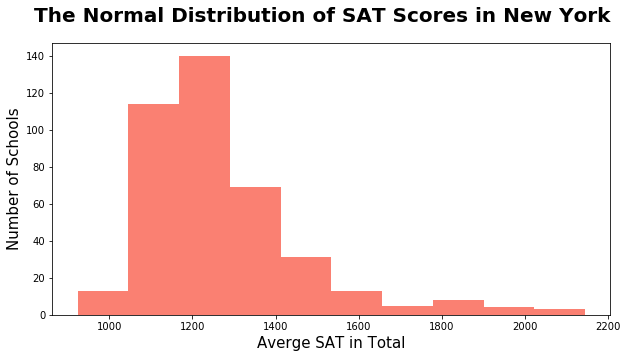

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('The Normal Distribution of SAT Scores in New York', fontsize=20, fontweight='bold')
satdata['Average SAT Score for Three sections'].plot(kind='hist', ax=ax, color='salmon')
ax.set_ylabel('Number of Schools', fontsize=15)
ax.set_xlabel('Averge SAT in Total', fontsize=15)

satdata['Average SAT Score for Three sections'].describe()

In this dataset, the mean public school score is 1273 and the median is 1227. There must be high scoring outliers that 
skew the distribution. 


Looking individually at seach section, the math section has the highest mean score of 431.88, writing of 417.5, and critical reading is lowest at 423.4.

Interestingly, if you have a look on the median scores of each of the three sections, you will find that Math has almost the same median to Critical Reading, while its mean is almost 10 points higher. This can only be explained that, high-SAT performance school usually did well in Math section. Looking at the violin plots below, you will see that,the high score tail of Math section is especially long compared to other two.

,Average Score SAT Math,Average Score SAT Critical Reading,Average Score SAT Writing
count,409.000000,409.000000,409.000000
mean,432.029340,423.493888,417.726161
std,70.490607,60.073734,62.989093
min,317.000000,302.000000,284.000000
25%,385.000000,386.000000,382.000000
50%,415.000000,413.000000,403.000000
75%,459.000000,443.000000,436.000000
max,754.000000,697.000000,693.000000


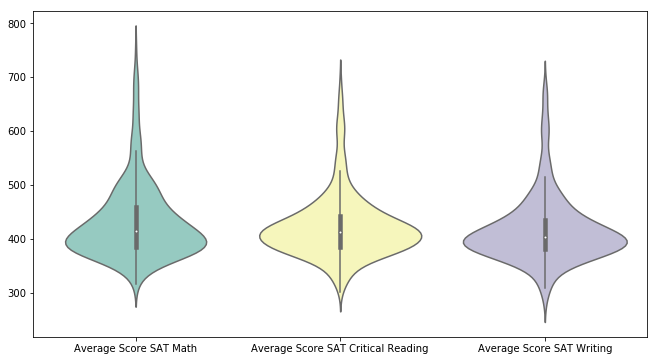

In [14]:
df2 = df[['Average Score SAT Math', 'Average Score SAT Critical Reading', \
          'Average Score SAT Writing']].copy()
f, ax = plt.subplots(figsize=(11, 6))
sns.violinplot(data=df2, palette="Set3")
df2.describe()

Below, we've also graphed schools based on subject focus. The 25 schools with "Science" in their school name scored  60 points higher on math than the average math and 160 points higher than the overall average. The 36 schools with "Arts" scored a little under the average in all three sections. 

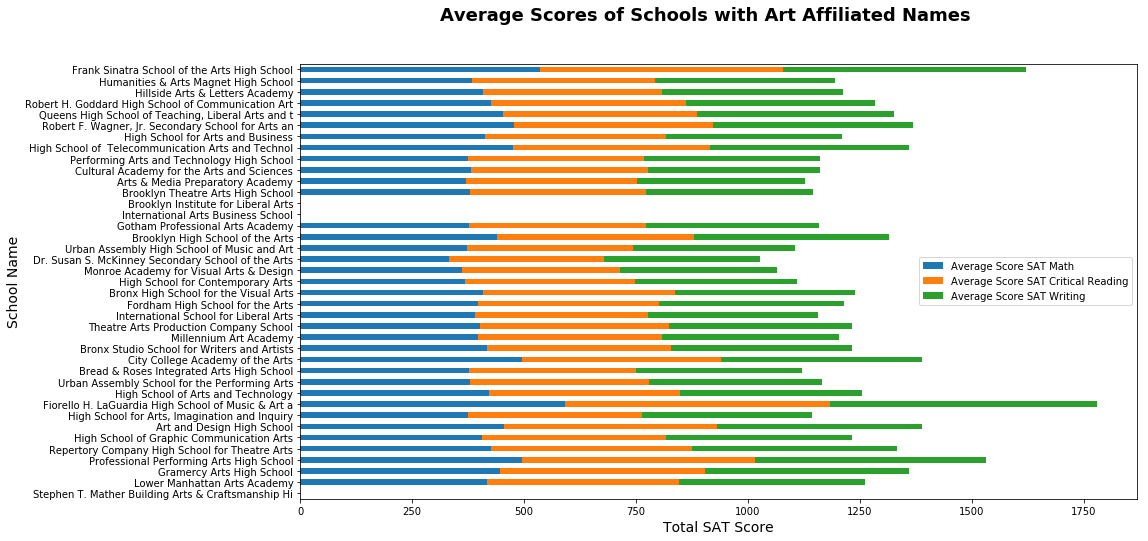

In [15]:
fig, ax = plt.subplots()
fig.suptitle('Average Scores of Schools with Art Affiliated Names', fontsize=18, fontweight='bold')
Art = df.loc[df['School Name'].str.contains("Art")]
ax.set_xlabel("Total SAT Score", fontsize=14)
ax.set_ylabel("School Name", fontsize=14)
Art = Art.set_index(['School Name'])
Art[['Average Score SAT Math', 'Average Score SAT Critical Reading', \
          'Average Score SAT Writing']].plot(kind="barh", ax = ax,
                 figsize=(15,8),
                 stacked=True)

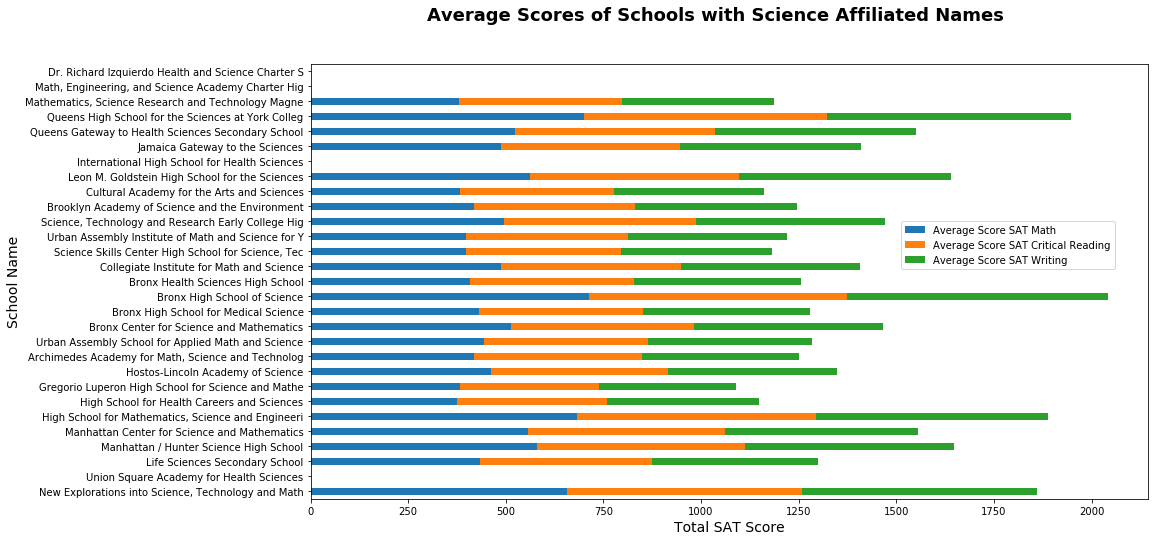

In [16]:
fig, ax = plt.subplots()
fig.suptitle('Average Scores of Schools with Science Affiliated Names', fontsize=18, fontweight='bold')
ax.set_xlabel("Total SAT Score", fontsize=14)
ax.set_ylabel("School Name", fontsize=14)
Science = df.loc[df['School Name'].str.contains("Science")]
Science = Science.set_index(['School Name'])
Science[['Average Score SAT Math', 'Average Score SAT Critical Reading', \
          'Average Score SAT Writing']].plot(kind="barh", ax = ax,
                 figsize=(15,8),
                 stacked=True)
ax.legend(bbox_to_anchor=(.7, .6, .001,.05),
          ncol=1, frameon= True)

In [17]:
Science.mean()

Average Score SAT Math                   491.840000
Average Score SAT Critical Reading       472.400000
Average Score SAT Writing                469.040000
Average SAT Score for Three sections    1235.586207
dtype: float64

In [18]:
Art.mean()

Average Score SAT Math                   417.277778
Average Score SAT Critical Reading       422.305556
Average Score SAT Writing                415.944444
Average SAT Score for Three sections    1158.948718
dtype: float64

While we have looked at specific subject-based schools, we also want to know: what does the typical New York High school look like? How many students does a 'typical' school enroll and how well does a New York high school do in general?

This is a very interesting question. The KDE plot uses the density to show us the highly populated area regarding the enrollment and SAT scores, which we can use to find the 'typical' New York High School: although the maximum students enrollment is 5447, most schools in New York enrolls between 400-600 students (the median is 483), and most of the students' SAT scores lie between 1100 to 1300 (the median is 1226). 

In [19]:
combo_num['Average SAT Score for Three sections'].describe()

count     491.000000
mean     1060.608961
std       506.030791
min         0.000000
25%      1103.500000
50%      1196.000000
75%      1304.000000
max      2144.000000
Name: Average SAT Score for Three sections, dtype: float64

count     491.000000
mean      678.757637
std       721.217027
min        12.000000
25%       353.000000
50%       465.000000
75%       651.000000
max      5447.000000
Name: Enrollment, dtype: float64

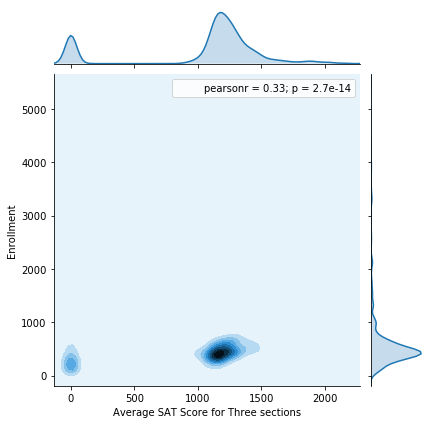

In [20]:
sns.jointplot(x='Average SAT Score for Three sections', y="Enrollment", data=combo_num, kind='kde')
combo_num['Enrollment'].describe()

## Highest and Lowest Scoring Schools

Let's take a look at the difference in scores between the top and bottom of the dataset.

In [21]:
satdata = satdata.rename(columns={"Average Score SAT Math":"avg_math", \
                                  "Average Score SAT Critical Reading":"avg_read", \
                                  "Average Score SAT Writing":"avg_write", \
                                  "Average SAT Score for Three sections":"avg_sat"})

schools = satdata.groupby('School Name')
sat_avg2 = schools['avg_sat'].agg([np.sum, np.mean, np.std]).sort_values(['mean'],
           ascending=False)

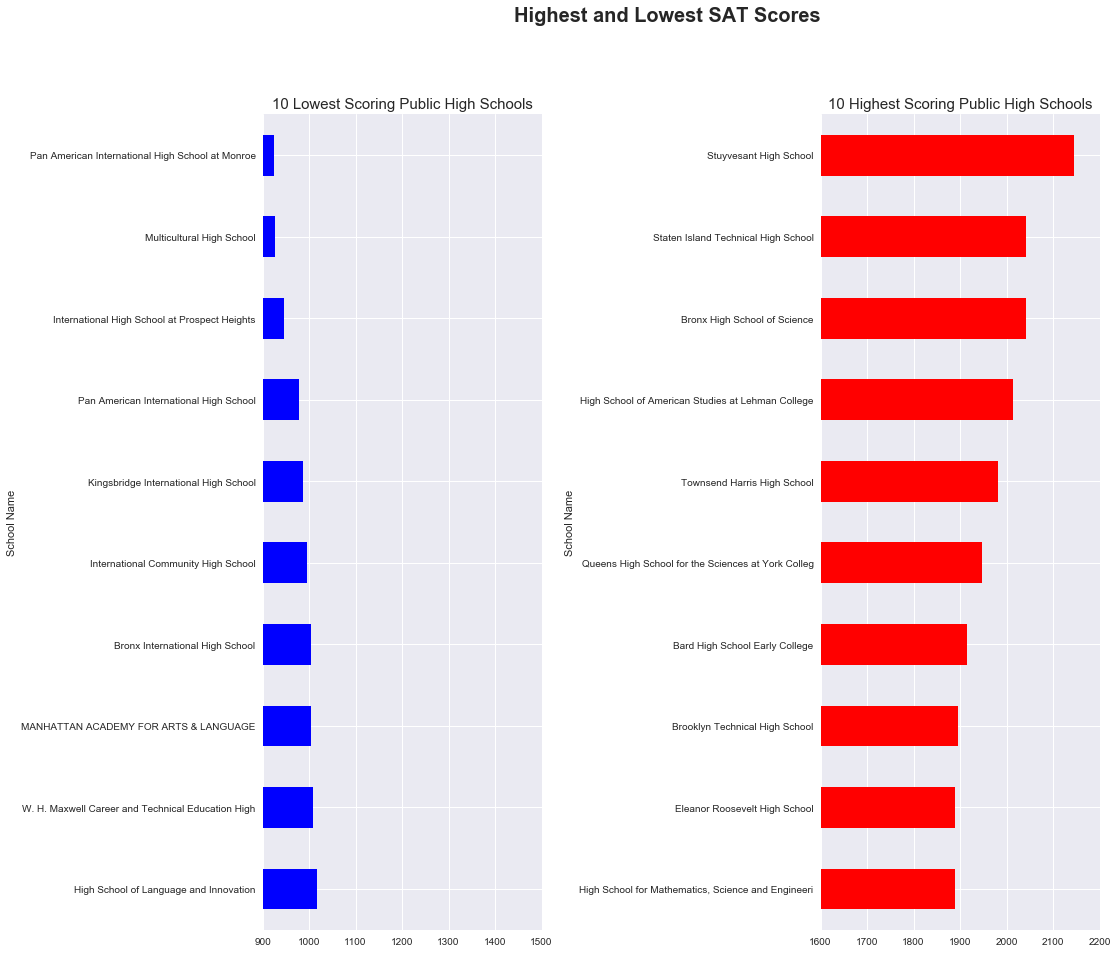

In [42]:
fig, ax = plt.subplots(1,2,figsize=(15, 15))
fig.suptitle('Highest and Lowest SAT Scores', fontsize=20, fontweight='bold')
fig.subplots_adjust(wspace=1)
sat_avg2['mean'].head(10).plot(kind='barh', ax=ax[1], color='r')
sat_avg2['mean'].tail(10).plot(kind='barh', ax=ax[0], color='b')
plt.gca().invert_yaxis() #show the highest and lowest score on top
plt.style.use("seaborn") #scale background
ax[0].set_title("10 Lowest Scoring Public High Schools", fontsize=15)
ax[1].set_title("10 Highest Scoring Public High Schools", fontsize=15)
ax[0].set_xlim(900,1500)
ax[1].set_xlim(1600,2200)

plt.show()

## What might be some causes for the disparity between scores?

### Income

Now that we've done some preliminary analysis, let's look at what factors correlate with scores. We will first use the U.S. Census API to locate annual household income data and merge it with our SAT dataframe.

In [23]:
satdf_top = satdata[["School Name","avg_math","avg_read","avg_write","avg_sat","borough","zip"]].copy()
satdf_top.sort_values(by="avg_sat",ascending=False, inplace=True)

code = ("B19013_001E") 
#code for median houshold income
    
zip_2015 = pd.DataFrame(c.acs5.get(code, 
                                         {'for': "zip code tabulation area:*"}, year=2015))
#the * will get all the zipcodes. Then we will merge so that only the zipcodes that are in  our dataset will appear.

zip_2015 = zip_2015.rename(columns={'zip code tabulation area':'zip', 
                                    'B19013_001E':'avg_income'})

zip_2015['zip'] = zip_2015['zip'].astype(str).astype(int)  
#In order to merge the datasets, we must first change the dtypes to be the same.

In [24]:
income_satdf = pd.merge(satdf_top,zip_2015,   
                     how='left',      # will merge with only the data in the left, which is our satdf_top
                 on='zip',       
                 indicator=True) 
income_satdf.head()

,School Name,avg_math,avg_read,avg_write,avg_sat,borough,zip,avg_income,_merge
0,Stuyvesant High School,754,697,693,2144,New_York,10282,250001.0,both
1,Bronx High School of Science,714,660,667,2041,Bronx,10468,34784.0,both
2,Staten Island Technical High School,711,660,670,2041,Staten_Island,10306,79686.0,both
3,High School of American Studies at Lehman College,669,672,672,2013,Bronx,10468,34784.0,both
4,Townsend Harris High School,680,640,661,1981,Queens,11367,56557.0,both


In [25]:
income_satdf.tail()

,School Name,avg_math,avg_read,avg_write,avg_sat,borough,zip,avg_income,_merge
395,Kingsbridge International High School,366,311,310,987,Bronx,10468,34784.0,both
396,Pan American International High School,340,320,318,978,Queens,11373,47588.0,both
397,International High School at Prospect Heights,344,302,300,946,Brooklyn,11225,44911.0,both
398,Multicultural High School,319,323,284,926,Brooklyn,11208,35698.0,both
399,Pan American International High School at Monroe,317,315,292,924,Bronx,10472,29308.0,both


In [26]:
income_satdf["avg_income"].head(10).mean()

81275.44444444444

In [27]:
income_satdf["avg_income"].tail(10).mean()

43274.0

In [28]:
income_satdf["avg_income"].describe()

count       399.000000
mean      55064.756892
std       28471.720311
min       20210.000000
25%       34476.500000
50%       46560.000000
75%       72411.500000
max      250001.000000
Name: avg_income, dtype: float64

The lowest scoring school, Pan American, has an average household income of **$30,000.**

Meanwhile, the zipcode of highest scoring school, Stuyvesant, has an average household income of ** $250,000.** 

The top 10 highest scoring schools have an average of $80,000, which is almost double the average income of the lowest scoring schools. 

One interesting thing to note is that the second highest scoring school, Bronx High School of Science, is in the same area as the one of the lowest scoring schools, Kingsbridge.

** Does this finding resonate in all the schools? Let's look at a map. **

Using the package geopandas, we can create a map of the New York City area and plot our dataset onto it. First, we had to get a [shape file](https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u/data) which contains the data of the district and zip code boundaries. Once it is downloaded, we can source it into the notebook.

In [29]:
path = "/Users/zhujunhan/Downloads/"

zip_file = path + "ZIP_CODE_040114" #this is for mac users

In [30]:
test = gpd.read_file(zip_file) #geopandas read in shape file
zipmap = pd.DataFrame(test) #make the file into a DF
test = test.rename(columns={'ZIPCODE':'zip'})
test['zip'] = test['zip'].astype(str).astype(int) #must change dtype from object to integer
test["zip"].dtypes #now that the zip is an integer, we can merge

dtype('int64')

In [31]:
zipmap  = test.merge(income_satdf, on='zip', how = "outer")
zipmap.head(2)

,zip,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,SHAPE_LEN,geometry,School Name,avg_math,avg_read,avg_write,avg_sat,borough,avg_income,_merge
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,...,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",Pathways in Technology Early College High Scho...,446.0,442.0,410.0,1298.0,Brooklyn,34701.0,both


/Users/zhujunhan/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


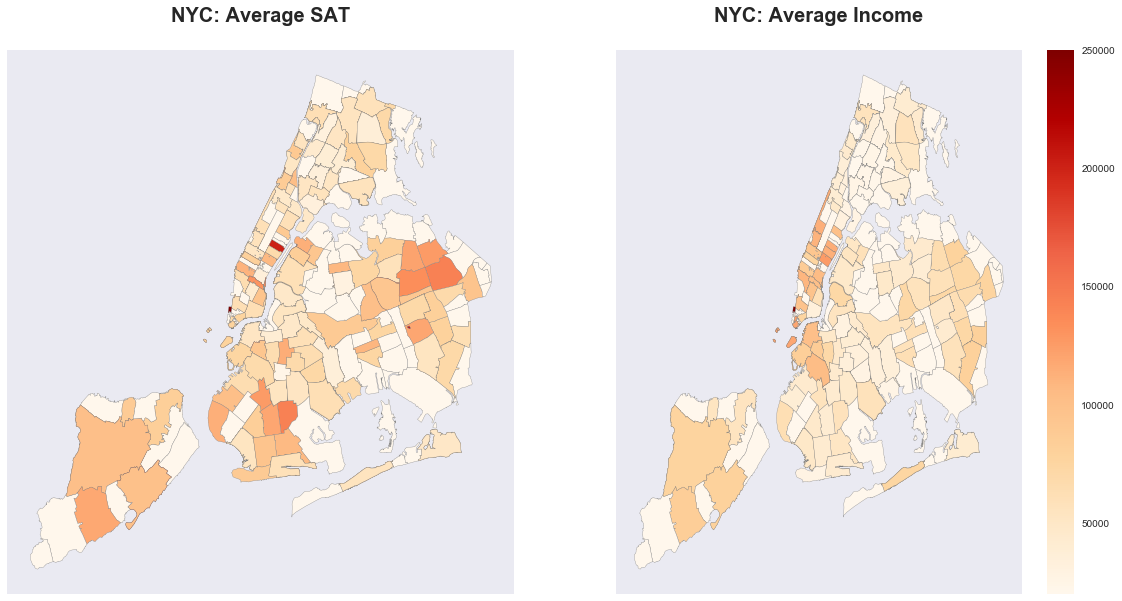

In [32]:
fig, ax = plt.subplots(1,2,figsize = (20,10))

######################################################################################
# Then lets create the map for SAT Scores

zipmap.plot(ax = ax[0], edgecolor='tab:grey', k =4,
             column='avg_sat',
            cmap='OrRd', alpha = 1.0, 
            #scheme="Quantiles",
            #legend=True
            )

######################################################################################    

ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["left"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)

ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

ax[0].set_title("NYC: Average SAT\n", fontsize=20, fontweight="bold")

######################################################################################
######################################################################################
# Then lets create the map for Income 

zipmap.plot(ax = ax[1], edgecolor='tab:grey', 
                column='avg_income', 
            legend=True,
             cmap='OrRd', 
            alpha = 1.0, 
             k=4, 
           )

######################################################################################
  
    
ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["left"].set_visible(False)
ax[1].spines["bottom"].set_visible(False)

ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

ax[1].set_title("NYC: Average Income\n",fontsize=20, fontweight="bold")


There is definitley a correlation as the darker shades on average income map also relfect a darker shade (higher score) on the SAT map. Areas of the map that are pale yellow score below the average SAT score are below $50,000 per house hold. The legend, indicating income, shows that there are only few regions in that have an income higher than 150,000.

### Looking at other variables that influence SAT Performance

Now let's look at more variables that might play an important part in determining the SAT scores for our students. We are particularly interested in some of the numerical variables:

* **Student Attendance Rate**:
    To explore if there is any correlation between attendence rate with scores


* **Economic Need Index**:
    To analyze if the economic need is an impedement for academic achievement


* **Percent English Language Learners**:
    To analyze what role language barrier plays in academic performance


* **Rigorous Instruction - Percent Positive**:
    To get a sense if rigorous teacher will teach more effectively in getting scores


* **Percent Asian/Black/Hispanic/White**:
    To analyze is there correlation between academic performance with ethnicity


And then, we will further explore the relationship in ratings form, we are particularly interested in some of the variables in qualtiative forms:

* **Quality Review - How clearly are high expectations communicated to students and staff?**:
To explore if there is any correlation between expressed expectations with standarlized performance


* **Quality Review - How interesting and challenging is the curriculum?**:
To analyze if the makings of intering/challenging courses foster academic achievement


* **Collaborative Teachers Rating**:
To get a sense if the collaborations between teacher and students will boost the performance in standarlized exams


* **Supportive Environment Rating**:
To analyze is there correlation between academic performance with races


* **Strong Family-Community Ties Rating**:
To find whether Family communication matters in academic performance in school


* **Effective School Leadership Rating'**:
To examine whether school leadership programs help students achieve better scores

In [33]:
# We have to change the names for our dataframes, or we will not be able to perform ols analysis on the name, because
# space will impede the code from running properly.
combo_num = combo_num.rename(columns={'Average SAT Score for Three sections':'avg_sat',
                                      'Average Score SAT Math':'avg_math', 
                                      'Average Score SAT Critical Reading':'avg_reading', 
                                      'Average Score SAT Writing':'avg_writing', 
                                      'Student Attendance Rate':'student_att', 
                                      'Average Grade 8 English Proficiency':'grade8_eng',
                                      'Average Grade 8 Math Proficiency':'grade8_math',
                                      'Percent English Language Learners':'learner_per',
                                      'Rigorous Instruction - Percent Positive':'rigo_ins',
                                      'Percent Asian':'asian_per',
                                      'Percent Black':'black_per',
                                      'Percent Hispanic':'hispanic_per',
                                      'Percent White':'white_per',
                                      'Economic Need Index':'eco_need'})

We will first do a linear regression analysis on the enrollment with SAT Score performance, and see what can we get from it.

In [34]:
result_1 = smf.ols("Enrollment ~ avg_sat",   
                  data=combo_num).fit()  
type(result_1) 
print(result_1.summary())    # This the provides a nice looking report

                            OLS Regression Results                            
Dep. Variable:             Enrollment   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     61.56
Date:                Thu, 21 Dec 2017   Prob (F-statistic):           2.73e-14
Time:                        22:16:16   Log-Likelihood:                -3898.3
No. Observations:                 491   AIC:                             7801.
Df Residuals:                     489   BIC:                             7809.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    173.3065     71.367      2.428      0.0

In [35]:
print("Parameter Estimates\n",result_1.params)
print("\n")
print("Confidence Intervales\n",result_1.conf_int())
print("\n")
print("R-Square\n",result_1.rsquared)

Parameter Estimates
 Intercept    173.306485
avg_sat        0.476567
dtype: float64


Confidence Intervales
                    0           1
Intercept  33.082968  313.530003
avg_sat     0.357220    0.595914


R-Square
 0.111807192102


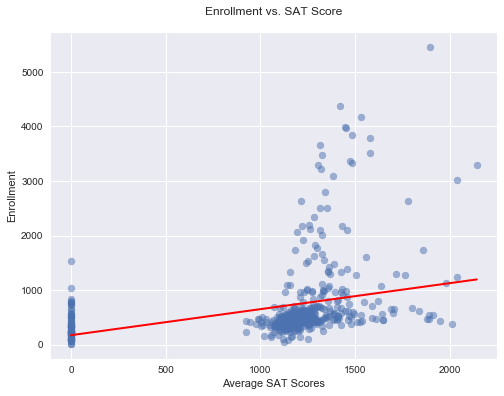

In [36]:
pred = result_1.predict(exog = combo_num["avg_sat"].sort_values())

fig, ax = plt.subplots(figsize = (8,6))

ax.scatter(combo_num["avg_sat"], 
         combo_num["Enrollment"], 
         alpha = 0.50)

ax.plot(combo_num["avg_sat"].sort_values(), pred , color = 'r', linewidth = 2.0)
       # Then I put in the sorted population values
       # then the precited trump share.... 

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_title("Enrollment vs. SAT Score\n")
ax.set_ylabel("Enrollment") 
ax.set_xlabel("Average SAT Scores")
plt.show()

There is a clear positive correlation between enrollment and SAT Performance. That is to say, in New York, students in bigger public high schools tend to get a higher scores than those in smaller ones.

To simplify analyzing the correlation among all the other factors, we use the Spearman correlation functions to analyze every factor in a dataframe, and generate their correlation factors with SAT Score performance, in order to do a direct comparison.

In [37]:
# we met a severe problem in the dataframe, because the percentage values is prohibited from any calculation. So we made
# a list of factors that we need to change, and perform a tranformation loop to perform the task at once.
                                        
list_change = ('student_att','eco_need', 'rigo_ins',\
               'learner_per','asian_per','black_per','white_per','hispanic_per')
for i in list_change:
    combo_num[i] = combo_num[i].str.replace('%', '').astype(str).astype(float)

In [38]:
combo_num

,DBN,School Name,avg_math,avg_reading,avg_writing,avg_sat,Enrollment,student_att,eco_need,grade8_eng,grade8_math,learner_per,rigo_ins,asian_per,black_per,hispanic_per,white_per,_merge
0,01M292,Henry Street School for International Studies,410.0,406.0,381.0,1197.0,255,76.6,83.2,2.18,2.06,12.7,72.0,13.2,24.4,56.6,3.9,both
1,01M448,University Neighborhood High School,437.0,355.0,352.0,1144.0,304,88.0,81.2,2.27,2.37,19.4,85.0,29.9,25.0,41.1,3.3,both
2,01M450,East Side Community School,454.0,428.0,445.0,1327.0,666,93.8,61.0,2.66,2.63,1.8,92.0,9.4,22.1,57.9,8.3,both
3,01M509,Marta Valle High School,438.0,413.0,394.0,1245.0,363,76.8,76.7,2.28,2.09,9.1,86.0,5.8,39.9,51.2,2.5,both
4,01M539,"New Explorations into Science, Technology and ...",657.0,601.0,601.0,1859.0,1735,95.2,25.7,3.50,3.53,0.2,81.0,38.5,13.3,18.0,28.6,both
5,01M696,Bard High School Early College,634.0,641.0,639.0,1914.0,545,95.8,31.4,3.71,3.65,0.0,92.0,17.1,17.2,18.7,45.3,both
6,02M047,47 The American Sign Language and English Seco...,NaN,NaN,NaN,0.0,169,88.1,73.3,2.40,2.24,4.7,79.0,1.2,28.4,64.5,5.3,both
7,02M135,The Urban Assembly School for Emergency Manage...,NaN,NaN,NaN,0.0,193,88.3,71.3,2.34,2.22,7.3,73.0,5.7,28.5,62.2,2.6,both
8,02M139,Stephen T. Mather Building Arts & Craftsmanshi...,NaN,NaN,NaN,0.0,193,88.1,71.4,2.30,2.27,7.8,85.0,3.6,24.9,61.1,8.8,both
9,02M280,Manhattan Early College School for Advertising,NaN,NaN,NaN,0.0,97,93.7,55.8,2.60,2.43,1.0,86.0,7.2,32.0,43.3,15.5,both


In [39]:
correlation = combo_num.drop(['_merge','DBN','avg_math','avg_reading','avg_writing',
           'School Name'], axis =1).corr(method = 'spearman')
correlation

,avg_sat,Enrollment,student_att,eco_need,grade8_eng,grade8_math,learner_per,rigo_ins,asian_per,black_per,hispanic_per,white_per
avg_sat,1.000000,0.601075,0.377743,-0.475607,0.620412,0.575285,-0.412594,0.082034,0.453827,-0.261584,-0.204134,0.386707
Enrollment,0.601075,1.000000,0.323477,-0.314568,0.462172,0.488269,-0.247291,-0.006193,0.278459,-0.239899,-0.100826,0.234404
student_att,0.377743,0.323477,1.000000,-0.586990,0.742775,0.799646,-0.545060,0.284802,0.336215,-0.211087,-0.309303,0.240723
eco_need,-0.475607,-0.314568,-0.586990,1.000000,-0.682352,-0.610478,0.543172,-0.211412,-0.624834,0.060177,0.651673,-0.567458
grade8_eng,0.620412,0.462172,0.742775,-0.682352,1.000000,0.909871,-0.745865,0.228430,0.444424,-0.112181,-0.417994,0.401748
grade8_math,0.575285,0.488269,0.799646,-0.610478,0.909871,1.000000,-0.604857,0.269807,0.467895,-0.254137,-0.318331,0.398579
learner_per,-0.412594,-0.247291,-0.545060,0.543172,-0.745865,-0.604857,1.000000,-0.112788,-0.103851,-0.248551,0.533521,-0.141978
rigo_ins,0.082034,-0.006193,0.284802,-0.211412,0.228430,0.269807,-0.112788,1.000000,0.159872,-0.138922,-0.082055,0.150326
asian_per,0.453827,0.278459,0.336215,-0.624834,0.444424,0.467895,-0.103851,0.159872,1.000000,-0.431440,-0.259595,0.748196
black_per,-0.261584,-0.239899,-0.211087,0.060177,-0.112181,-0.254137,-0.248551,-0.138922,-0.431440,1.000000,-0.523325,-0.488082


The dataframe is very complicated to get a sense of it. So we decided to visualize it by using pandas plot, while neglect the unnecessary columns. To make it even better, we ranked the factors, so you can see what is more powerful in influencing the SAT scores.

count    12.000000
mean      0.228597
std       0.473049
min      -0.475607
25%      -0.218496
50%       0.382225
75%       0.581733
max       1.000000
Name: avg_sat, dtype: float64

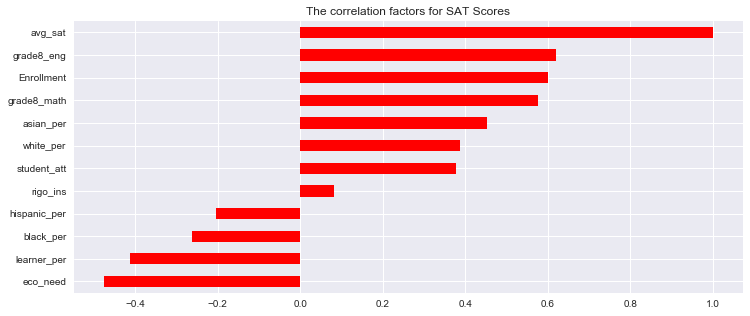

In [40]:
corr = correlation['avg_sat'].sort_values()
corr.plot.barh(figsize = (12,5),color = 'r', \
               title="The correlation factors for SAT Scores")
correlation['avg_sat'].describe()

In the plot above, we can conclude that the most powerful factor that has the positive correlation with SAT performance is Average Grade 8 English Proficiency. The most negative factor is Economic Need Index. This also proves the previous conclusion that the economic status is very important in determining SAT scores.

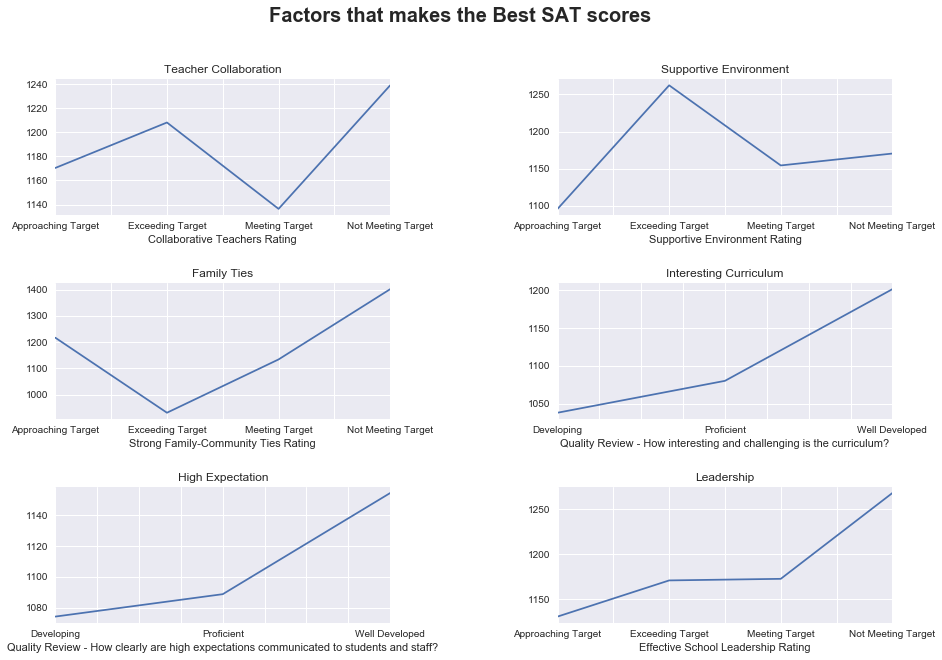

In [41]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize = (15,10))
fig.suptitle('Factors that makes the Best SAT scores', fontsize=20, fontweight='bold')
fig.subplots_adjust(hspace=.5, wspace=.5)
var_1 = combo_rate.groupby('Collaborative Teachers Rating')
avg_sat1 = var_1['Average SAT Score for Three sections'].agg([np.sum, np.mean, np.std])

var_2 = combo_rate.groupby('Supportive Environment Rating')
avg_sat2 = var_2['Average SAT Score for Three sections'].agg([np.sum, np.mean, np.std])

var_3 = combo_rate.groupby('Strong Family-Community Ties Rating')
avg_sat3 = var_3['Average SAT Score for Three sections'].agg([np.sum, np.mean, np.std])

var_4 = combo_rate.groupby('Quality Review - How interesting and challenging is the curriculum?')
avg_sat4 = var_4['Average SAT Score for Three sections'].agg([np.sum, np.mean, np.std])

var_5 = combo_rate.groupby('Quality Review - How clearly are high expectations communicated to students and staff?')
avg_sat5 = var_5['Average SAT Score for Three sections'].agg([np.sum, np.mean, np.std])

var_6 = combo_rate.groupby('Effective School Leadership Rating')
avg_sat6 = var_6['Average SAT Score for Three sections'].agg([np.sum, np.mean, np.std])

avg_sat1['mean'].plot(title="Teacher Collaboration", ax=ax[0,0])
avg_sat2['mean'].plot(title="Supportive Environment", ax=ax[0,1])
avg_sat3['mean'].plot(title="Family Ties", ax=ax[1,0])
avg_sat4['mean'].plot(title="Interesting Curriculum", ax=ax[1,1])
avg_sat5['mean'].plot(title="High Expectation", ax=ax[2,0])
avg_sat6['mean'].plot(title="Leadership", ax=ax[2,1])

After making a list of all the possible factors that may influence the average SAT scores performance, we are very surprised to see the following observations:

* Family Ties plays an negative correlation with the Students performance in SAT, that is to say, the less students communicate with their family, they tend to score higher.


* Leadership factor also acts weird in correlation with SAT scores. Students in high schools that don't foster leadership skills (indicated as "Not Meeting the Target") tend to perform the best relatively to other school.


* As for expectations, students in schools that are proficient in expressing high expectations to students and staff tend to score not much higher than schools with developing expecations. But the well-developed school sky-rocked in SAT scores.


* Other factors such as collaboration, interesting curriculum, supportive environment all have a positive correlation with SAT performance as we expected.

## Conclusion

By looking at the visualizations of the New York Public High School performance data, we were able to find some very interesting correlations between SAT scores performance, school envrionment, and external factors. 

Schools with STEM association in their names proved to score higher than the avergae, while schools with "Arts" in their name did below average. Note, both made up only small samples overall. In regards to income, most of the map lays between the bracket of $40,000 to $70,000 per household, with the median being $47,000. In terms of school environment, we were able to identify the positive correlation factors (that help students performance better in SAT exams) and the negative correlation factors (that deteriorate students' performance in SAT exams). 

Positive correlation factors are: 
* Student Attendance Rate
* Average Grade 8 English Proficiency
* Average Grade 8 Math Proficiency 

The negative correlation factors: 
* Economic Need Index
* Percent English Language Learners

There were also positive correlations for Percentage Asian and White and negative correlations with Percentage Black
and Hispanic. We would like to do more research into what factors specifically influence these correlations. 

Surprisingly, we concluded from the factor that, although rigorous teaching has positive correlation with SAT Scores, it is the least effective approach. Teachers should seek other methods such as collaboration, interesting curriculum, supportive environment. Not surprisingly, we were able to comfirm that the biggest barrier that prevents students from achieving a good SAT score is economic status. Economic Need Index is the most powerful negative correlation factor for SAT scores, and we also showed the similar result using census data API.

Through processing the csv file, analyzing and plotting, we met a lot of challenges along the way. Our analysis has created good insight, however, our project can still be improved by using more census data to map with DBN and yield more factors to analyze, as well as diving into specifics within each borough. We would love to keep finalizing our project by filtering out the outliers such as the school with abnormal high scores, small enrollment etc. to make our data more reliable. Additionally with the redesigned SAT, we would like to see over time how students respond to the change. 